In [1]:
from dotenv import load_dotenv
import os
from google.cloud import bigquery
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_theme(style="whitegrid")

In [2]:
load_dotenv()
key = os.getenv("linkfile")
client = bigquery.Client.from_service_account_json(key)

In [3]:
query_clean = """
SELECT DISTINCT
  carrier,
  departure_date,
  origin,
  destination,
  economy_emissions_grams_per_pax  AS economy
FROM
  `bigquery-public-data.travel_impact_model.flights_impact_data`
WHERE
  economy_emissions_grams_per_pax > 0
LIMIT 30000;
"""

df = client.query(query_clean).to_dataframe()
df.head()

,carrier,departure_date,origin,destination,economy
0,SK,2024-03-25,CPH,AAL,30353
1,SK,2024-12-03,CPH,AAL,30353
2,SK,2024-08-23,CPH,AAL,30353
3,D8,2024-08-15,CPH,AAL,30712
4,D8,2025-01-31,CPH,AAL,36916


In [4]:
df.describe(include='all')

,carrier,departure_date,origin,destination,economy
count,30000,30000,30000,30000,30000.0
unique,508,367,2177,2209,<NA>
top,DL,2024-06-15,ATL,ATL,<NA>
freq,1735,123,369,346,<NA>
mean,NaN,NaN,NaN,NaN,123973.735933
std,NaN,NaN,NaN,NaN,210151.14706
min,NaN,NaN,NaN,NaN,15718.0
25%,NaN,NaN,NaN,NaN,63741.75
50%,NaN,NaN,NaN,NaN,93377.0
75%,NaN,NaN,NaN,NaN,135614.0


In [5]:
df.isna().sum()

carrier           0
departure_date    0
origin            0
destination       0
economy           0
dtype: int64

In [6]:
df.dtypes

carrier           object
departure_date    dbdate
origin            object
destination       object
economy            Int64
dtype: object

In [7]:
df.duplicated().sum()

np.int64(0)

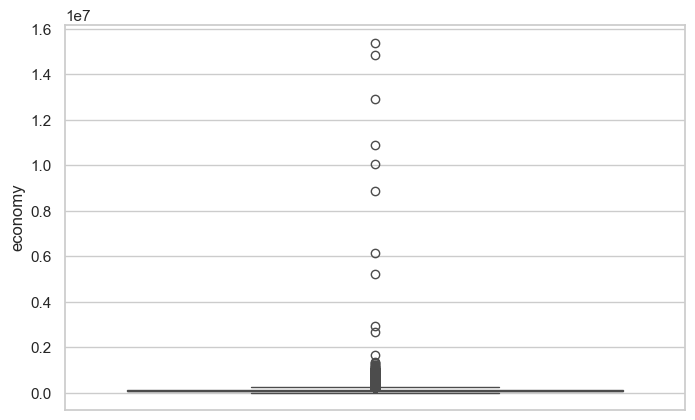

In [8]:
plt.figure(figsize=(8,5))
sns.boxplot(y=df["economy"])
plt.xticks()
plt.show()

In [9]:
def remove_outliers_iqr(df, column):
    df[column] = df[column].astype(float)

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df.loc[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df_filtered


In [10]:
df1 = remove_outliers_iqr(df, "economy")

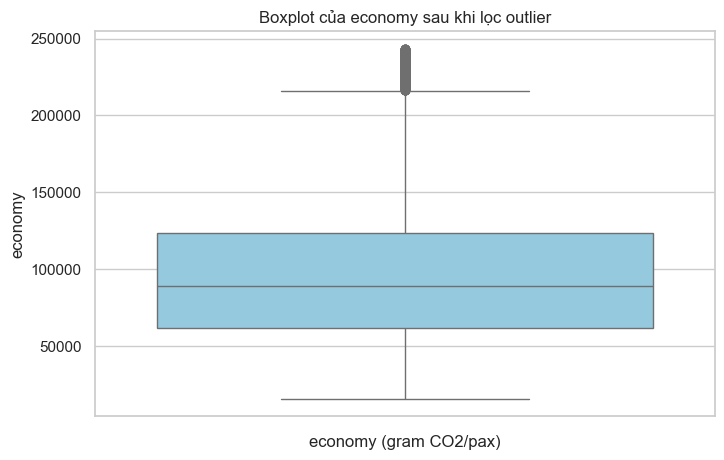

In [11]:
plt.figure(figsize=(8,5))
sns.boxplot(y=df1["economy"], color="skyblue")
plt.title("Boxplot của economy sau khi lọc outlier")
plt.xlabel("economy (gram CO2/pax)")
plt.show()

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27807 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carrier         27807 non-null  object 
 1   departure_date  27807 non-null  dbdate 
 2   origin          27807 non-null  object 
 3   destination     27807 non-null  object 
 4   economy         27807 non-null  float64
dtypes: dbdate(1), float64(1), object(3)
memory usage: 1.3+ MB


In [13]:
df1["economy"].describe()

count     27807.000000
mean      97246.438199
std       47026.990083
min       15718.000000
25%       61701.500000
50%       88938.000000
75%      123522.000000
max      243367.000000
Name: economy, dtype: float64

In [14]:
df1.duplicated().sum()

np.int64(0)

In [15]:
df1['departure_date'] = pd.to_datetime(df1['departure_date'], errors='coerce')

In [16]:
df1['year'] = df1['departure_date'].dt.year
df1['month'] = df1['departure_date'].dt.month
df1['day'] = df1['departure_date'].dt.day

df1.head()

,carrier,departure_date,origin,destination,economy,year,month,day
0,SK,2024-03-25,CPH,AAL,30353.0,2024,3,25
1,SK,2024-12-03,CPH,AAL,30353.0,2024,12,3
2,SK,2024-08-23,CPH,AAL,30353.0,2024,8,23
3,D8,2024-08-15,CPH,AAL,30712.0,2024,8,15
4,D8,2025-01-31,CPH,AAL,36916.0,2025,1,31


In [17]:
df1['day_of_week'] = df1['departure_date'].dt.dayofweek
df1['quarter'] = df1['departure_date'].dt.quarter

df1.head()


,carrier,departure_date,origin,destination,economy,year,month,day,day_of_week,quarter
0,SK,2024-03-25,CPH,AAL,30353.0,2024,3,25,0,1
1,SK,2024-12-03,CPH,AAL,30353.0,2024,12,3,1,4
2,SK,2024-08-23,CPH,AAL,30353.0,2024,8,23,4,3
3,D8,2024-08-15,CPH,AAL,30712.0,2024,8,15,3,3
4,D8,2025-01-31,CPH,AAL,36916.0,2025,1,31,4,1


In [18]:
df1['sin_month'] = np.sin(2 * np.pi * df1['month'] / 12)
df1['cos_month'] = np.cos(2 * np.pi * df1['month'] / 12)

df1.head()

,carrier,departure_date,origin,destination,economy,year,month,day,day_of_week,quarter,sin_month,cos_month
0,SK,2024-03-25,CPH,AAL,30353.0,2024,3,25,0,1,1.000000e+00,6.123234e-17
1,SK,2024-12-03,CPH,AAL,30353.0,2024,12,3,1,4,-2.449294e-16,1.000000e+00
2,SK,2024-08-23,CPH,AAL,30353.0,2024,8,23,4,3,-8.660254e-01,-5.000000e-01
3,D8,2024-08-15,CPH,AAL,30712.0,2024,8,15,3,3,-8.660254e-01,-5.000000e-01
4,D8,2025-01-31,CPH,AAL,36916.0,2025,1,31,4,1,5.000000e-01,8.660254e-01


In [19]:
df1['sin_dayofweek'] = np.sin(2 * np.pi * df1['day_of_week'] / 7)
df1['cos_dayofweek'] = np.cos(2 * np.pi * df1['day_of_week'] / 7)

df1.head()

,carrier,departure_date,origin,destination,economy,year,month,day,day_of_week,quarter,sin_month,cos_month,sin_dayofweek,cos_dayofweek
0,SK,2024-03-25,CPH,AAL,30353.0,2024,3,25,0,1,1.000000e+00,6.123234e-17,0.000000,1.000000
1,SK,2024-12-03,CPH,AAL,30353.0,2024,12,3,1,4,-2.449294e-16,1.000000e+00,0.781831,0.623490
2,SK,2024-08-23,CPH,AAL,30353.0,2024,8,23,4,3,-8.660254e-01,-5.000000e-01,-0.433884,-0.900969
3,D8,2024-08-15,CPH,AAL,30712.0,2024,8,15,3,3,-8.660254e-01,-5.000000e-01,0.433884,-0.900969
4,D8,2025-01-31,CPH,AAL,36916.0,2025,1,31,4,1,5.000000e-01,8.660254e-01,-0.433884,-0.900969


In [20]:
def get_season(month):
    if month in [12, 1, 2]:
        return "winter"   
    elif month in [3, 4, 5]:
        return "spring"  
    elif month in [6, 7, 8]:
        return "summer"   
    else:
        return "autumn"   


In [21]:
df1['season'] = df1['month'].apply(get_season)
df1.head()

,carrier,departure_date,origin,destination,economy,year,month,day,day_of_week,quarter,sin_month,cos_month,sin_dayofweek,cos_dayofweek,season
0,SK,2024-03-25,CPH,AAL,30353.0,2024,3,25,0,1,1.000000e+00,6.123234e-17,0.000000,1.000000,spring
1,SK,2024-12-03,CPH,AAL,30353.0,2024,12,3,1,4,-2.449294e-16,1.000000e+00,0.781831,0.623490,winter
2,SK,2024-08-23,CPH,AAL,30353.0,2024,8,23,4,3,-8.660254e-01,-5.000000e-01,-0.433884,-0.900969,summer
3,D8,2024-08-15,CPH,AAL,30712.0,2024,8,15,3,3,-8.660254e-01,-5.000000e-01,0.433884,-0.900969,summer
4,D8,2025-01-31,CPH,AAL,36916.0,2025,1,31,4,1,5.000000e-01,8.660254e-01,-0.433884,-0.900969,winter


In [22]:
def trend_by_month(month):
    if 4 < month <= 9:
        return "on_dinh"
    elif month in [10, 11, 12]:
        return "tang"
    elif month in [1, 2]:
        return "ngang"
    else:
        return "giam"
df1['trend_by_month'] = df1['month'].apply(trend_by_month)
df1.head()

,carrier,departure_date,origin,destination,economy,year,month,day,day_of_week,quarter,sin_month,cos_month,sin_dayofweek,cos_dayofweek,season,trend_by_month
0,SK,2024-03-25,CPH,AAL,30353.0,2024,3,25,0,1,1.000000e+00,6.123234e-17,0.000000,1.000000,spring,giam
1,SK,2024-12-03,CPH,AAL,30353.0,2024,12,3,1,4,-2.449294e-16,1.000000e+00,0.781831,0.623490,winter,tang
2,SK,2024-08-23,CPH,AAL,30353.0,2024,8,23,4,3,-8.660254e-01,-5.000000e-01,-0.433884,-0.900969,summer,on_dinh
3,D8,2024-08-15,CPH,AAL,30712.0,2024,8,15,3,3,-8.660254e-01,-5.000000e-01,0.433884,-0.900969,summer,on_dinh
4,D8,2025-01-31,CPH,AAL,36916.0,2025,1,31,4,1,5.000000e-01,8.660254e-01,-0.433884,-0.900969,winter,ngang


In [23]:
X = df1.drop("departure_date", axis=1)

In [24]:
X = X.rename(columns={"economy": "gramco2"})

In [25]:
X.head()

,carrier,origin,destination,gramco2,year,month,day,day_of_week,quarter,sin_month,cos_month,sin_dayofweek,cos_dayofweek,season,trend_by_month
0,SK,CPH,AAL,30353.0,2024,3,25,0,1,1.000000e+00,6.123234e-17,0.000000,1.000000,spring,giam
1,SK,CPH,AAL,30353.0,2024,12,3,1,4,-2.449294e-16,1.000000e+00,0.781831,0.623490,winter,tang
2,SK,CPH,AAL,30353.0,2024,8,23,4,3,-8.660254e-01,-5.000000e-01,-0.433884,-0.900969,summer,on_dinh
3,D8,CPH,AAL,30712.0,2024,8,15,3,3,-8.660254e-01,-5.000000e-01,0.433884,-0.900969,summer,on_dinh
4,D8,CPH,AAL,36916.0,2025,1,31,4,1,5.000000e-01,8.660254e-01,-0.433884,-0.900969,winter,ngang


In [26]:
size_in_bytes = X.memory_usage(deep=True).sum()
size_in_gb = size_in_bytes / (1024**3)
print(f"Kích thước DataFrame: {size_in_gb:.2f} GB")

Kích thước DataFrame: 0.01 GB


In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27807 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carrier         27807 non-null  object 
 1   origin          27807 non-null  object 
 2   destination     27807 non-null  object 
 3   gramco2         27807 non-null  float64
 4   year            27807 non-null  int32  
 5   month           27807 non-null  int32  
 6   day             27807 non-null  int32  
 7   day_of_week     27807 non-null  int32  
 8   quarter         27807 non-null  int32  
 9   sin_month       27807 non-null  float64
 10  cos_month       27807 non-null  float64
 11  sin_dayofweek   27807 non-null  float64
 12  cos_dayofweek   27807 non-null  float64
 13  season          27807 non-null  object 
 14  trend_by_month  27807 non-null  object 
dtypes: float64(5), int32(5), object(5)
memory usage: 2.9+ MB


In [28]:
X_ = X[['sin_month', 'cos_month','sin_dayofweek', 'cos_dayofweek','gramco2']]

In [29]:
from sklearn.preprocessing import OneHotEncoder


categorical_cols = ['season','carrier', 'origin', 'destination', 'year','quarter','month', 'day']


ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = ohe.fit_transform(X[categorical_cols])
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
X_cat_df = pd.DataFrame(X_cat, columns=cat_feature_names, index=X.index)


X_encoded = pd.concat([X_cat_df,X_], axis=1)
X_encoded.shape

(27807, 4904)

In [30]:
X_encoded = X_encoded.dropna()

In [31]:
X_encoded.shape

(27807, 4904)

In [32]:
size_in_bytes = X_encoded.memory_usage(deep=True).sum()
size_in_gb = size_in_bytes / (1024**3)
print(f"Kích thước DataFrame: {size_in_gb:.2f} GB")

Kích thước DataFrame: 1.02 GB


In [33]:
X_encoded.to_csv("train.csv", index=False)

In [34]:
from joblib import dump
dump(ohe, "model/onehot_encoder.pkl")

['model/onehot_encoder.pkl']